In [129]:
import sys
import subprocess
python = sys.executable
subprocess.check_call(
    [python, '-m', 'pip', 'install', '--upgrade', '-r', 'requirement.txt'],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.STDOUT  #Suppress error messages
)

print(">>> requirements checked <<<\n")

>>> requirements checked <<<



In [130]:
# Parameters for network generation
n = 1000 # number of nodes
m = 2 # number of edges per node
d = 2 # number of dimensions
tau = 2.5 # threshold for edge weights
alpha = 2 # power-law exponent for degree distribution
expected_weight = 1 # expected weight of edges

# UPN/SEIRD model parameters
beta_u = 0.1 
beta_p = 0.2 * beta_u 
beta_n = 0.2 * beta_u 
sigma = 1 / 10 
gamma = 1 / 14 
f = 0.01 
kappa = 1 
lambda_plus = 1.0 
lambda_minus = 1.0 
delta_plus = 1 / 3 
delta_minus = 1 / 3 

# Initial conditions
initial_infected = 5
initial_aware = 10
i_0 = initial_infected / n
a_0 = initial_aware / n

# Simulation parameters
t_max = 150
dt = 0.01

In [131]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import powerlaw

def generate_ba_network(n, m):
    return nx.barabasi_albert_graph(n, m)

def generate_girg_network(n, d, tau, alpha, expected_weight):
    class GIRG:
        def __init__(self, n, d, tau, alpha, expected_weight):
            self.n = n
            self.d = d
            self.tau = tau
            self.alpha = alpha
            self.expected_weight = expected_weight
            self.positions = np.random.uniform(size=(n, d))
            self.weights = self._generate_weights(tau, n)
            self.graph = self._generate_graph()

        def _generate_weights(self, tau, size):
            weights = powerlaw.Power_Law(xmin=1, parameters=[tau-1]).generate_random(size)
            weights = weights / np.mean(weights) * self.expected_weight
            return weights

        def _distance_matrix(self):
            return squareform(pdist(self.positions))

        def _generate_graph(self):
            dist_matrix = self._distance_matrix()
            graph = nx.Graph()
            for i in range(self.n):
                for j in range(i + 1, self.n):
                    if dist_matrix[i, j] == 0:
                        dist_matrix[i, j] = np.inf  # Avoid division by zero
                    p = 1 - np.exp(- (self.weights[i] * self.weights[j]) / (dist_matrix[i, j] ** self.alpha))
                    if np.random.random() < p:
                        graph.add_edge(i, j)
            return graph

    girg = GIRG(n, d, tau, alpha, expected_weight)
    return girg.graph

class MultiLayerNetwork:
    def __init__(self, n_nodes):
        self.n_nodes = n_nodes
        self.physical_layer = None
        self.virtual_layer = None
        self.node_mapping = {i: i for i in range(n_nodes)}  # Maps nodes between layers

    def generate_layers(self, physical_type, virtual_type):
        self.physical_layer = generate_network_until_size_met(choose_network, physical_type, self.n_nodes)
        self.virtual_layer = generate_network_until_size_met(choose_network, virtual_type, self.n_nodes)

    def get_physical_neighbors(self, node):
        return list(self.physical_layer.neighbors(self.node_mapping[node]))

    def get_virtual_neighbors(self, node):
        return list(self.virtual_layer.neighbors(self.node_mapping[node]))

def generate_multilayer_network(n, physical_type, virtual_type):
    multi_layer_network = MultiLayerNetwork(n)
    multi_layer_network.generate_layers(physical_type, virtual_type)
    return multi_layer_network

# Generate networks
G_ba = generate_ba_network(n, m)
G_girg = generate_girg_network(n, d, tau, alpha, expected_weight)
G_multi = generate_multilayer_network(n, 'BA', 'GIRG')

# Modify the plot_degree_distribution function to handle multilayer networks
def plot_degree_distribution(G, title):
    if isinstance(G, MultiLayerNetwork):
        degrees_physical = [G.physical_layer.degree(n) for n in G.physical_layer.nodes()]
        degrees_virtual = [G.virtual_layer.degree(n) for n in G.virtual_layer.nodes()]
        
        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 2, 1)
        degree_counts = np.bincount(degrees_physical)
        degree_probs = degree_counts / sum(degree_counts)
        plt.loglog(range(len(degree_probs)), degree_probs, marker='o')
        plt.xlabel('Degree')
        plt.ylabel('Probability')
        plt.title(f'{title} - Physical Layer')
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        degree_counts = np.bincount(degrees_virtual)
        degree_probs = degree_counts / sum(degree_counts)
        plt.loglog(range(len(degree_probs)), degree_probs, marker='o')
        plt.xlabel('Degree')
        plt.ylabel('Probability')
        plt.title(f'{title} - Virtual Layer')
        plt.grid(True)
        
        plt.tight_layout()
    else:
        degrees = [G.degree(n) for n in G.nodes()]
        degree_counts = np.bincount(degrees)
        degree_probs = degree_counts / sum(degree_counts)
        
        plt.figure(figsize=(10, 6))
        plt.loglog(range(len(degree_probs)), degree_probs, marker='o')
        plt.xlabel('Degree')
        plt.ylabel('Probability')
        plt.title(title)
        plt.grid(True)
    
    plt.show()
    
# Function to choose and generate network based on type
def choose_network(network_type, n):
    if network_type == 'BA':
        return generate_ba_network(n, m)
    elif network_type == 'GIRG':
        return generate_girg_network(n, d, tau, alpha, expected_weight)
    elif network_type == 'Multi':
        return generate_girg_network(n)
    else:
        raise ValueError("Unknown network type")
    
# Function to ensure network generation meets the size requirement
def generate_network_until_size_met(choose_network_function, layer_type, target_n):
    G = choose_network_function(layer_type, target_n)
    while G.number_of_nodes() != target_n:
        G = choose_network_function(layer_type, target_n)
    return G

In [132]:
# Function to initialize state variables
def initialize_states(N, initial_infected, initial_aware, i_0, a_0):
    S = np.full(N, 1.0, dtype=float)
    E = np.zeros(N, dtype=float)
    I = np.zeros(N, dtype=float)
    R = np.zeros(N, dtype=float)
    D = np.zeros(N, dtype=float)
    U = np.full(N, 1.0 - a_0, dtype=float)
    P = np.zeros(N, dtype=float)
    N_nodes = np.zeros(N, dtype=float)

    infected_nodes = np.random.choice(np.arange(N), initial_infected, replace=False)
    aware_nodes = np.random.choice(np.arange(N), initial_aware, replace=False)

    I[infected_nodes] = 1
    U[aware_nodes] = 0
    P[aware_nodes] = 1 - a_0

    U[aware_nodes] = 0
    P[aware_nodes] = 1
    N_nodes[aware_nodes] = 0
    total = U + P + N_nodes
    U /= total
    P /= total
    N_nodes /= total

    return S, E, I, R, D, U, P, N_nodes

# Function to run the simulation
def simulate_upn_seird_seperate(adjacency_matrix_epidemic, adjacency_matrix_info, t_max, dt, beta_u, sigma, gamma, f, kappa, lambda_plus, lambda_minus, delta_plus, delta_minus, initial_infected, initial_aware, i_0, a_0):
    N = len(adjacency_matrix_epidemic)
    S, E, I, R, D, U, P, N_nodes = initialize_states(N, initial_infected, initial_aware, i_0, a_0)

    time_steps = np.arange(0, t_max, dt)

    S_list = []
    E_list = []
    I_list = []
    R_list = []
    D_list = []
    U_list = []
    P_list = []
    N_list = []

    print("Starting the simulation...")
    epsilon = 1e-10

    for t_index, t in enumerate(time_steps):
        if t_index % 100 == 0:
            print(f"Simulation at time step {t_index}/{len(time_steps)} (time = {t:.1f})")
        
        dot_I = adjacency_matrix_epidemic.dot(I)
        dot_P = adjacency_matrix_info.dot(P)
        dot_N_nodes = adjacency_matrix_info.dot(N_nodes)
        
        new_E = (beta_u * S * dot_I) * dt
        new_I = (sigma * E) * dt
        new_R = ((1 - f) * gamma * I) * dt
        new_D = (f * gamma * I) * dt
        new_P = (lambda_plus * U * dot_P + kappa * I * U) * dt
        new_U_from_P = (delta_plus * P) * dt
        new_N = (lambda_minus * U * dot_N_nodes + kappa * I * U) * dt
        new_U_from_N = (delta_minus * N_nodes) * dt
        
        np.clip(S - new_E, 0, 1, out=S)
        np.clip(E + new_E - new_I, 0, 1, out=E)
        np.clip(I + new_I - new_R - new_D, 0, 1, out=I)
        np.clip(R + new_R, 0, 1, out=R)
        np.clip(D + new_D, 0, 1, out=D)
        np.clip(U - new_P - new_N + new_U_from_P + new_U_from_N, 0, 1, out=U)
        np.clip(P + new_P - new_U_from_P, 0, 1, out=P)
        np.clip(N_nodes + new_N - new_U_from_N, 0, 1, out=N_nodes)
        
        UPN_total = U + P + N_nodes + epsilon
        U /= UPN_total
        P /= UPN_total
        N_nodes /= UPN_total
        
        S_list.append(np.mean(S))
        E_list.append(np.mean(E))
        I_list.append(np.mean(I))
        R_list.append(np.mean(R))
        D_list.append(np.mean(D))
        U_list.append(np.mean(U))
        P_list.append(np.mean(P))
        N_list.append(np.mean(N_nodes))

    return S_list, E_list, I_list, R_list, D_list, U_list, P_list, N_list

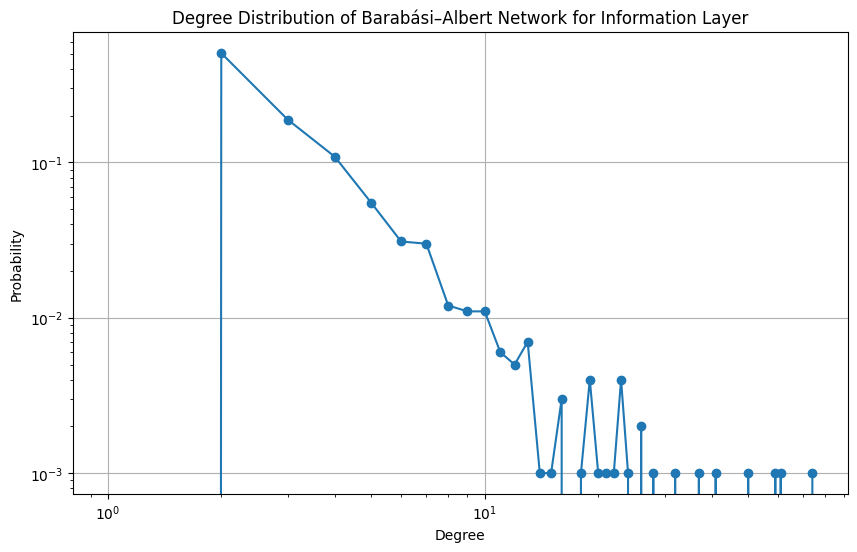

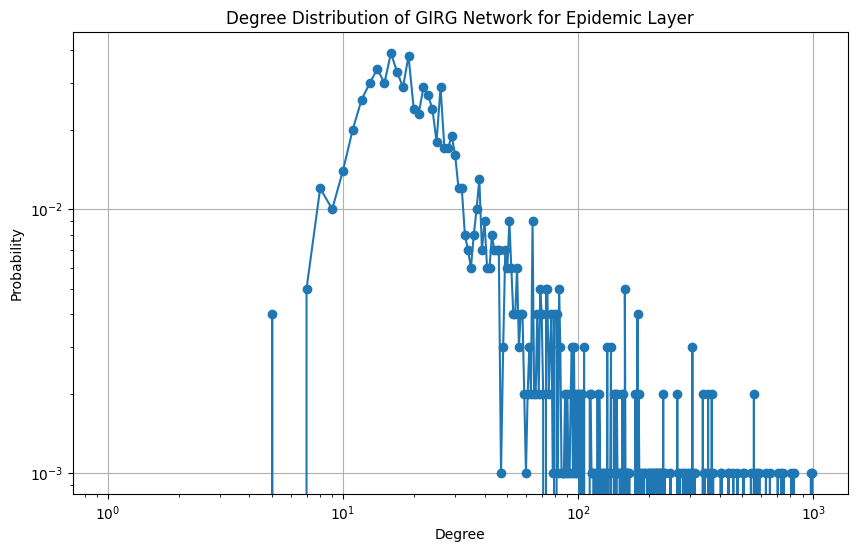

Starting the simulation...
Simulation at time step 0/15000 (time = 0.0)
Simulation at time step 100/15000 (time = 1.0)
Simulation at time step 200/15000 (time = 2.0)
Simulation at time step 300/15000 (time = 3.0)
Simulation at time step 400/15000 (time = 4.0)
Simulation at time step 500/15000 (time = 5.0)
Simulation at time step 600/15000 (time = 6.0)
Simulation at time step 700/15000 (time = 7.0)
Simulation at time step 800/15000 (time = 8.0)
Simulation at time step 900/15000 (time = 9.0)
Simulation at time step 1000/15000 (time = 10.0)
Simulation at time step 1100/15000 (time = 11.0)
Simulation at time step 1200/15000 (time = 12.0)
Simulation at time step 1300/15000 (time = 13.0)
Simulation at time step 1400/15000 (time = 14.0)
Simulation at time step 1500/15000 (time = 15.0)
Simulation at time step 1600/15000 (time = 16.0)
Simulation at time step 1700/15000 (time = 17.0)
Simulation at time step 1800/15000 (time = 18.0)
Simulation at time step 1900/15000 (time = 19.0)
Simulation at t

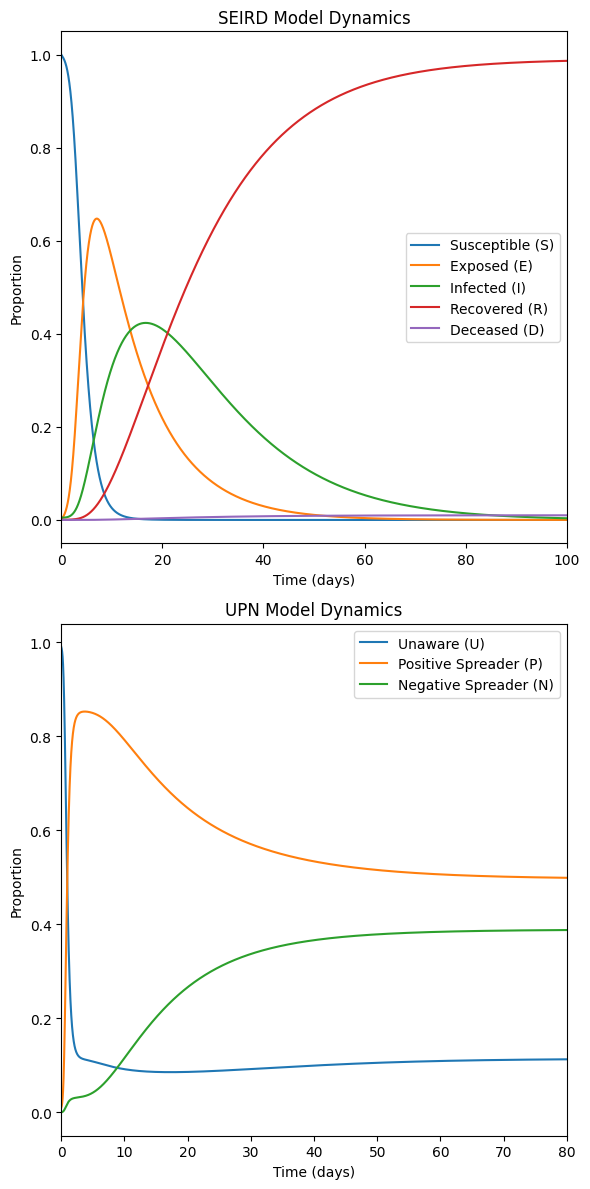

In [137]:
# Choose networks
epidemic_layer_type = 'GIRG'  # Change as needed: 'BA', 'GIRG'
infomation_layer_type = 'BA'  # Change as needed: 'BA', 'GIRG'

# Generate the network for both layers
G_info = generate_network_until_size_met(choose_network, infomation_layer_type, n)
G_epidemic = generate_network_until_size_met(choose_network, epidemic_layer_type, n)

# Plot degree distributions
plot_degree_distribution(G_info, 'Degree Distribution of Barabási–Albert Network for Information Layer')
plot_degree_distribution(G_epidemic, 'Degree Distribution of GIRG Network for Epidemic Layer')

# Convert network to adjacency matrix
adjacency_matrix_info = nx.to_numpy_array(G_info)
adjacency_matrix_epidemic = nx.to_numpy_array(G_epidemic)

# Run the simulation
S, E, I, R, D, U, P, N = simulate_upn_seird_seperate(adjacency_matrix_epidemic, adjacency_matrix_info, t_max, dt, beta_u, sigma, gamma, f, kappa, lambda_plus, lambda_minus, delta_plus, delta_minus, initial_infected, initial_aware, i_0, a_0)

# plotting
time_steps = np.arange(0, t_max, dt)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

ax1.set_xlim(0, 100)
ax1.plot(time_steps, S, label='Susceptible (S)')
ax1.plot(time_steps, E, label='Exposed (E)')
ax1.plot(time_steps, I, label='Infected (I)')
ax1.plot(time_steps, R, label='Recovered (R)')
ax1.plot(time_steps, D, label='Deceased (D)')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Proportion')
ax1.legend()
ax1.set_title('SEIRD Model Dynamics')

ax2.set_xlim(0, 80)
ax2.plot(time_steps, U, label='Unaware (U)')
ax2.plot(time_steps, P, label='Positive Spreader (P)')
ax2.plot(time_steps, N, label='Negative Spreader (N)')
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Proportion')
ax2.legend()
ax2.set_title('UPN Model Dynamics')

plt.tight_layout()
plt.show()

In [134]:
def simulate_upn_seird_multiplex(multi_network, t_max, dt, beta_u, sigma, gamma, f, kappa, lambda_plus, lambda_minus, delta_plus, delta_minus, initial_infected, initial_aware, i_0, a_0):
    N = multi_network.n_nodes
    S, E, I, R, D, U, P, N_nodes = initialize_states(N, initial_infected, initial_aware, i_0, a_0)

    time_steps = np.arange(0, t_max, dt)

    # Lists for storing results
    S_list, E_list, I_list, R_list, D_list, U_list, P_list, N_list = [], [], [], [], [], [], [], []

    print("Starting the simulation...")

    # Pre-compute neighbors once if the network does not change
    physical_neighbors_list = [multi_network.get_physical_neighbors(node) for node in range(N)]
    virtual_neighbors_list = [multi_network.get_virtual_neighbors(node) for node in range(N)]

    for t_index, t in enumerate(time_steps):
        if t_index % 100 == 0:
            print(f"Simulation at time step {t_index}/{len(time_steps)} (time = {t:.1f})")

        dot_I = np.zeros(N)
        dot_P = np.zeros(N)
        dot_N_nodes = np.zeros(N)

        # Vectorized computation of new states
        for node in range(N):
            dot_I[node] = I[physical_neighbors_list[node]].sum()
            dot_P[node] = P[virtual_neighbors_list[node]].sum()
            dot_N_nodes[node] = N_nodes[virtual_neighbors_list[node]].sum()

        # Update states using vectorized operations
        new_E = beta_u * S * dot_I * dt
        new_I = sigma * E * dt
        new_R = gamma * I * dt
        new_D = f * gamma * I * dt
        new_P = (lambda_plus * U * dot_P + kappa * I * U) * dt
        new_N = (lambda_minus * U * dot_N_nodes + kappa * I * U) * dt

        S -= new_E
        E += new_E - new_I
        I += new_I - new_R - new_D
        R += new_R
        D += new_D
        U -= new_P + new_N
        P += new_P - delta_plus * P * dt
        N_nodes += new_N - delta_minus * N_nodes * dt

        # Ensure non-negativity and normalization in a vectorized manner
        S, E, I, R, D, U, P, N_nodes = [np.maximum(state, 0) for state in [S, E, I, R, D, U, P, N_nodes]]

        total = S + E + I + R + D
        S, E, I, R, D = [state / total for state in [S, E, I, R, D]]

        total_info = U + P + N_nodes
        U, P, N_nodes = [state / total_info for state in [U, P, N_nodes]]

        # Append current state averages to lists
        S_list.append(S.mean())
        E_list.append(E.mean())
        I_list.append(I.mean())
        R_list.append(R.mean())
        D_list.append(D.mean())
        U_list.append(U.mean())
        P_list.append(P.mean())
        N_list.append(N_nodes.mean())

    return S_list, E_list, I_list, R_list, D_list, U_list, P_list, N_list

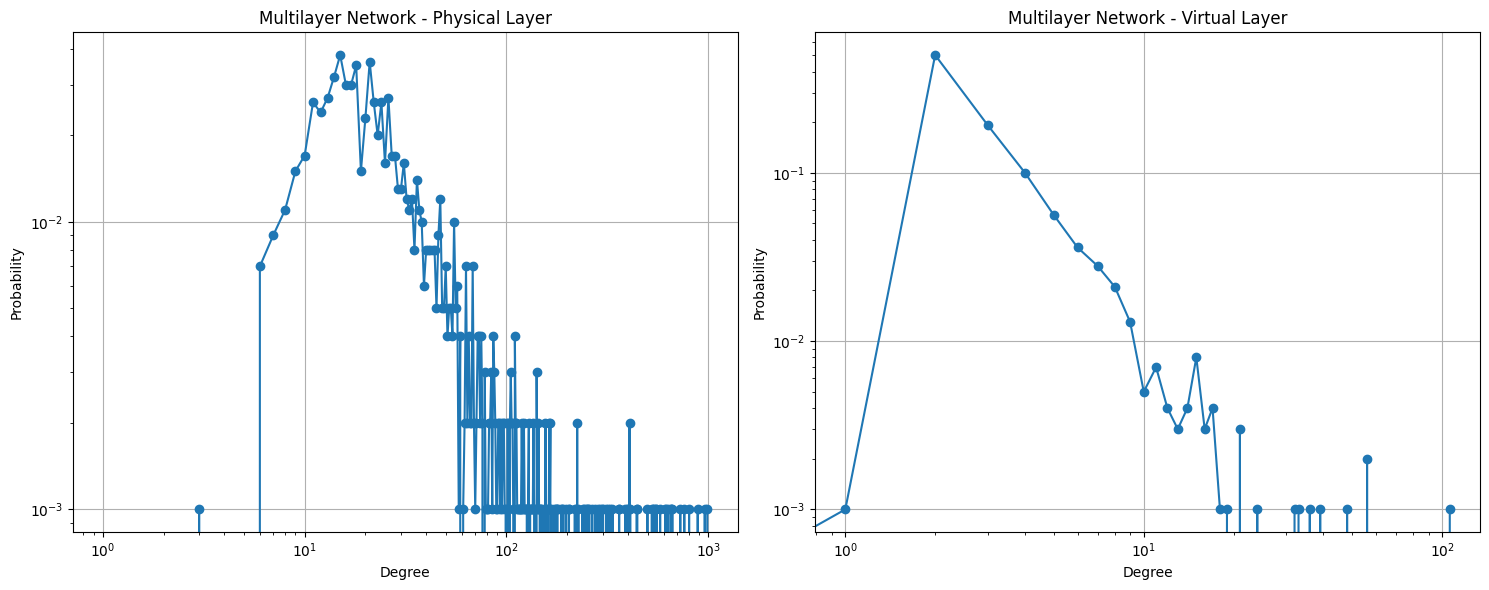

Starting the simulation...
Simulation at time step 0/15000 (time = 0.0)
Simulation at time step 100/15000 (time = 1.0)
Simulation at time step 200/15000 (time = 2.0)
Simulation at time step 300/15000 (time = 3.0)
Simulation at time step 400/15000 (time = 4.0)
Simulation at time step 500/15000 (time = 5.0)
Simulation at time step 600/15000 (time = 6.0)
Simulation at time step 700/15000 (time = 7.0)
Simulation at time step 800/15000 (time = 8.0)
Simulation at time step 900/15000 (time = 9.0)
Simulation at time step 1000/15000 (time = 10.0)
Simulation at time step 1100/15000 (time = 11.0)
Simulation at time step 1200/15000 (time = 12.0)
Simulation at time step 1300/15000 (time = 13.0)
Simulation at time step 1400/15000 (time = 14.0)
Simulation at time step 1500/15000 (time = 15.0)
Simulation at time step 1600/15000 (time = 16.0)
Simulation at time step 1700/15000 (time = 17.0)
Simulation at time step 1800/15000 (time = 18.0)
Simulation at time step 1900/15000 (time = 19.0)
Simulation at t

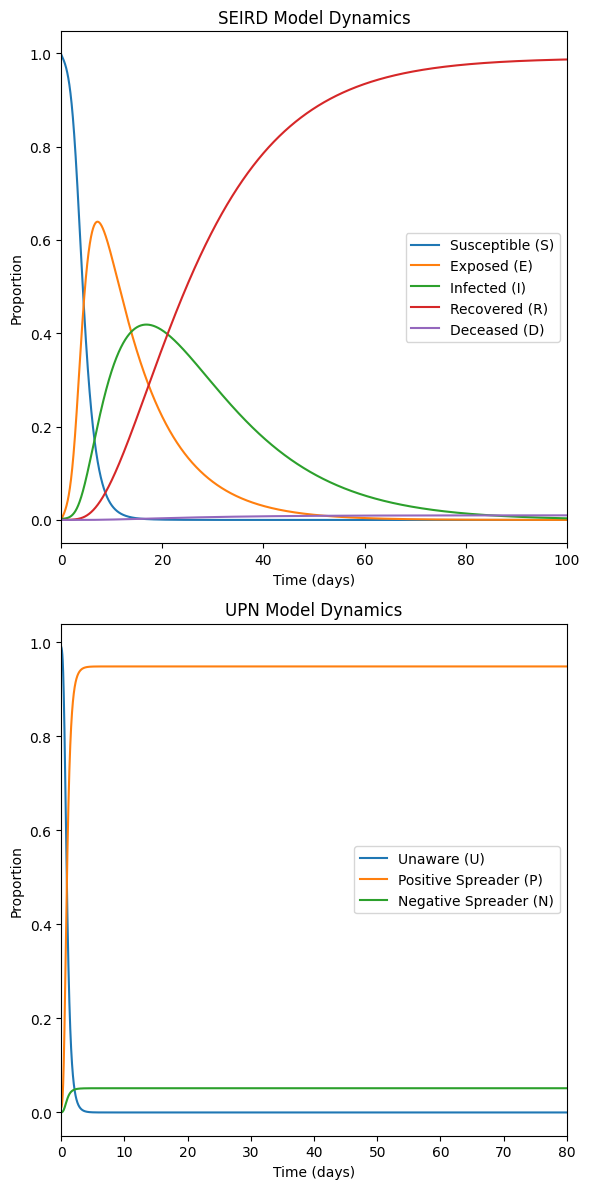

In [138]:
# Choose networks
epidemic_layer_type = 'GIRG'  # Change as needed: 'BA', 'GIRG'
information_layer_type = 'BA'  # Change as needed: 'BA', 'GIRG'

# Generate the multilayer network
multi_network = generate_multilayer_network(n, epidemic_layer_type, information_layer_type)

# Plot degree distributions
plot_degree_distribution(multi_network, 'Multilayer Network')

# Run the simulation
S, E, I, R, D, U, P, N = simulate_upn_seird_multiplex(multi_network, t_max, dt, beta_u, sigma, gamma, f, kappa, lambda_plus, lambda_minus, delta_plus, delta_minus, initial_infected, initial_aware, i_0, a_0)

# plotting
time_steps = np.arange(0, t_max, dt)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

ax1.set_xlim(0, 100)
ax1.plot(time_steps, S, label='Susceptible (S)')
ax1.plot(time_steps, E, label='Exposed (E)')
ax1.plot(time_steps, I, label='Infected (I)')
ax1.plot(time_steps, R, label='Recovered (R)')
ax1.plot(time_steps, D, label='Deceased (D)')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Proportion')
ax1.legend()
ax1.set_title('SEIRD Model Dynamics')

ax2.set_xlim(0, 80)
ax2.plot(time_steps, U, label='Unaware (U)')
ax2.plot(time_steps, P, label='Positive Spreader (P)')
ax2.plot(time_steps, N, label='Negative Spreader (N)')
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Proportion')
ax2.legend()
ax2.set_title('UPN Model Dynamics')

plt.tight_layout()
plt.show()

In [ ]:
def run_mmc_simulations(n_simulations, multi_network, t_max, dt, beta_u, sigma, gamma, f, kappa, lambda_plus, lambda_minus, delta_plus, delta_minus, initial_infected, initial_aware, i_0, a_0):
    results = []
    for i in range(n_simulations):
        print(f"Running simulation {i+1}/{n_simulations}")
        sim_result = simulate_upn_seird_multiplex(multi_network, t_max, dt, beta_u, sigma, gamma, f, kappa, lambda_plus, lambda_minus, delta_plus, delta_minus, initial_infected, initial_aware, i_0, a_0)
        results.append(sim_result)
    
    # Aggregate results
    mean_results = np.mean(results, axis=0)
    std_results = np.std(results, axis=0)
    
    return mean_results, std_results

# Run MMC simulations
n_simulations = 2  # Adjust as needed
mean_results, std_results = run_mmc_simulations(n_simulations, multi_network, t_max, dt, beta_u, sigma, gamma, f, kappa, lambda_plus, lambda_minus, delta_plus, delta_minus, initial_infected, initial_aware, i_0, a_0)

# Plot results with error bars
time_steps = np.arange(0, t_max, dt)
plt.figure(figsize=(12, 8))
compartments = ['S', 'E', 'I', 'R', 'D', 'U', 'P', 'N']
for i, comp in enumerate(compartments):
    plt.errorbar(time_steps, mean_results[i], yerr=std_results[i], label=comp)
plt.xlabel('Time (days)')
plt.ylabel('Proportion')
plt.title('UPN-SEIRD Model Dynamics (Monte Carlo Simulations)')
plt.legend()
plt.show()

Starting the simulation...
Simulation at time step 0/15000 (time = 0.0)
Simulation at time step 100/15000 (time = 1.0)
Simulation at time step 200/15000 (time = 2.0)
Simulation at time step 300/15000 (time = 3.0)
Simulation at time step 400/15000 (time = 4.0)
Simulation at time step 500/15000 (time = 5.0)
Simulation at time step 600/15000 (time = 6.0)
Simulation at time step 700/15000 (time = 7.0)
Simulation at time step 800/15000 (time = 8.0)
Simulation at time step 900/15000 (time = 9.0)
Simulation at time step 1000/15000 (time = 10.0)
Simulation at time step 1100/15000 (time = 11.0)
Simulation at time step 1200/15000 (time = 12.0)
Simulation at time step 1300/15000 (time = 13.0)
Simulation at time step 1400/15000 (time = 14.0)
Simulation at time step 1500/15000 (time = 15.0)
Simulation at time step 1600/15000 (time = 16.0)
Simulation at time step 1700/15000 (time = 17.0)
Simulation at time step 1800/15000 (time = 18.0)
Simulation at time step 1900/15000 (time = 19.0)
Simulation at t

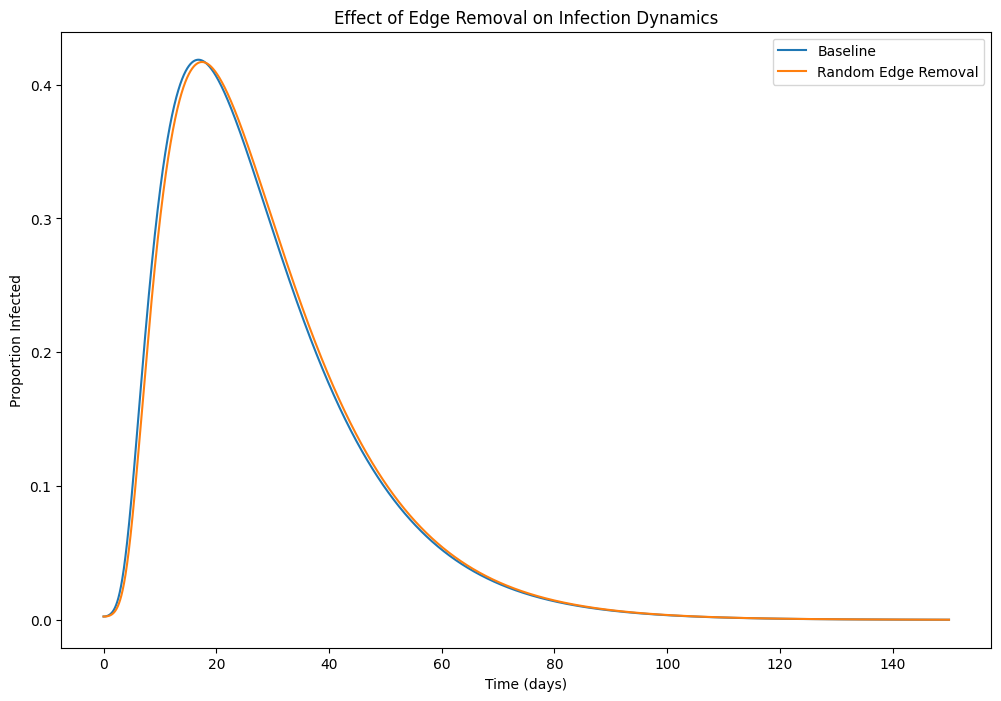

In [139]:
import random

def remove_edges(multi_network, removal_type, fraction):
    if removal_type == 'random':
        edges_to_remove = random.sample(list(multi_network.physical_layer.edges()), int(fraction * multi_network.physical_layer.number_of_edges()))
    elif removal_type == 'targeted':
        # Implement targeted removal based on node degree or other criteria
        pass
    else:
        raise ValueError("Unknown removal type")
    
    multi_network.physical_layer.remove_edges_from(edges_to_remove)
    return multi_network

# Example usage
multi_network_random_removal = remove_edges(multi_network, 'random', 0.1)
S_random, E_random, I_random, R_random, D_random, U_random, P_random, N_random = simulate_upn_seird_multiplex(multi_network_random_removal, t_max, dt, beta_u, sigma, gamma, f, kappa, lambda_plus, lambda_minus, delta_plus, delta_minus, initial_infected, initial_aware, i_0, a_0)

# Compare results
plt.figure(figsize=(12, 8))
plt.plot(time_steps, I, label='Baseline')
plt.plot(time_steps, I_random, label='Random Edge Removal')
plt.xlabel('Time (days)')
plt.ylabel('Proportion Infected')
plt.title('Effect of Edge Removal on Infection Dynamics')
plt.legend()
plt.show()